# Practice Session PS05: Recommendation engines (Content-based)

Author: <font color="blue">Luca Franceschi</font>

E-mail: <font color="blue">luca.franceschi01@estudiant.upf.edu</font>

Date: <font color="blue">12/11/2024</font>

In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
from math import *
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel

# 1. Load and join the dataset

In [2]:
# Leave this code as-is
DIR = 'movielens-25M-filtered/'
FILENAME_MOVIES = DIR + 'movies-2000s.csv'
FILENAME_RATINGS = DIR + 'ratings-2000s.csv'
FILENAME_TAGS = DIR + 'tags-2000s.csv'

In [3]:
# Leave this code as-is

movies = pd.read_csv(
    FILENAME_MOVIES,
    sep=',',
    engine='python',
    encoding='latin-1',
    names=['movie_id', 'title', 'genres'],
)
display(movies.head(5))

ratings_raw = pd.read_csv(
    FILENAME_RATINGS,
    sep=',',
    encoding='latin-1',
    engine='python',
    names=['user_id', 'movie_id', 'rating'],
)
display(ratings_raw.head(5))

,movie_id,title,genres
0,2769,"Yards, The (2000)",Crime|Drama
1,3177,Next Friday (2000),Comedy
2,3190,Supernova (2000),Adventure|Sci-Fi|Thriller
3,3225,Down to You (2000),Comedy|Romance
4,3228,Wirey Spindell (2000),Comedy


,user_id,movie_id,rating
0,4,1,3.0
1,4,260,3.5
2,4,296,4.0
3,4,541,4.5
4,4,589,4.0


<font size="+1" color="red">Replace this cell with your own code to add a `year` column to the `movies` dataframe.</font>

In [4]:
def yearof(in_str: str):
    return int(re.search(r'\(([0-9]{4})\)', in_str).group(1))

In [5]:
movies['year'] = movies.apply(lambda x: yearof(x['title']), axis=1)

display(movies.head(5))

,movie_id,title,genres,year
0,2769,"Yards, The (2000)",Crime|Drama,2000
1,3177,Next Friday (2000),Comedy,2000
2,3190,Supernova (2000),Adventure|Sci-Fi|Thriller,2000
3,3225,Down to You (2000),Comedy|Romance,2000
4,3228,Wirey Spindell (2000),Comedy,2000


<font size="+1" color="red">Replace this cell with a brief commentary indicating on which field you can join ratings_raw and movies.</font>

We can join the two 'raw' datasets by the foreign key 'movie_id', since it identifies a movie in the two datasets separately.

<font size="+1" color="red">Replace this cell with your own code to join the datasets into a single dataframe named "ratings". Your dataframe should have the following columns: user_id, movie_id, rating, title, genres, year</font>

In [6]:
ratings = pd.merge(ratings_raw, movies, how='inner', on='movie_id')
display(ratings.head(5))

,user_id,movie_id,rating,title,genres,year
0,4,3624,2.5,Shanghai Noon (2000),Action|Adventure|Comedy|Western,2000
1,4,3751,3.5,Chicken Run (2000),Animation|Children|Comedy,2000
2,4,3793,1.5,X-Men (2000),Action|Adventure|Sci-Fi,2000
3,4,3827,3.0,Space Cowboys (2000),Action|Adventure|Comedy|Sci-Fi,2000
4,4,4308,3.5,Moulin Rouge (2001),Drama|Musical|Romance,2001


In [7]:
ratings['movie_id'].dtype

dtype('int64')

<font size="+1" color="red">Replace this cell with your code for find _movies</font>

In [8]:
def find_movies(query_str: str, df: pd.DataFrame):
    query = df.apply(lambda x: query_str in x['title'], axis=1)
    print(df[query][['movie_id', 'title']])


find_movies('Barcelona', movies)

       movie_id                             title
3839      60950   Vicky Cristina Barcelona (2008)
25401    182911  Barcelona Christmas Night (2015)


# 2. Exploratory Data Analysis

## 2.1. "Rating" variable

In [9]:
# LEAVE AS-IS

ratings['rating'].describe()

count    472971.000000
mean          3.462222
std           1.076063
min           0.500000
25%           3.000000
50%           3.500000
75%           4.000000
max           5.000000
Name: rating, dtype: float64

<font size="+1" color="red">Replace this cell with your code to plot a histogram of ratings. Include in the x axis the rating (1, 2, 3, 4, or 5) and in the y axis the probability of having that rating. Remember to label both axes.</font>

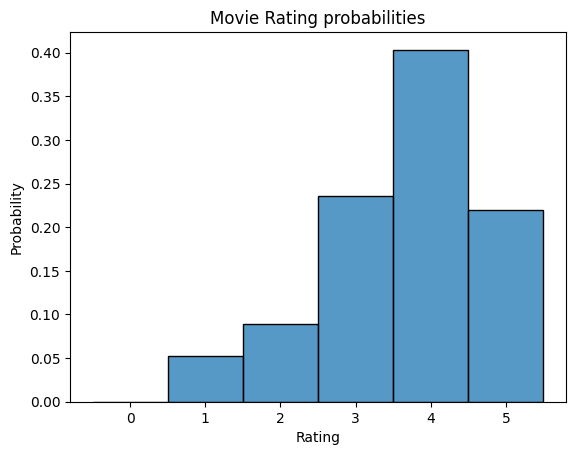

In [10]:
fig = plt.figure()
sns.histplot(ratings['rating'], binrange=[-0.5, 5.5], bins=6, stat='density')
plt.xlabel('Rating')
plt.ylabel('Probability')
plt.title('Movie Rating probabilities')
plt.show()

I have included a 0 bin in case there was a 0-star review (not used in this specific case), which I would consider possible since the minimum rating is 0.5 (and not 1). Bins represent the rounded rating (both 0.5 and 1.49 would be represented in the 1-star rating bin).

<font size="+1" color="red">Replace this cell with your code to plot a boxplot of ratings. Look for outlier values. </font>

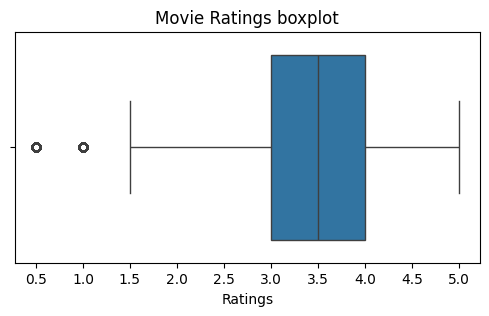

In [11]:
fig = plt.figure(figsize=(6, 3))
sns.boxplot(ratings['rating'], orient='h')
plt.xlabel('Ratings')
plt.title('Movie Ratings boxplot')
plt.xticks(np.arange(0.5, 5.5, 0.5))
plt.show()

We can see that there are outlier values below 1.5 (namely 1 and 0.5). They might seem very few but we have to take into account that if there are multiple datapoints having the same value there is an overlap between them, and only one is shown.

<font size="+1" color="red">Replace this cell with a brief commentary on what you observe in the distribution of ratings.</font>

In [12]:
int(ratings['rating'].count() * 0.05)

23648

We can see that 50% of ratings are between 3 and 4 (between quantiles 1 and 3). From the boxplot itself we cannot see how many outliers are there since they are plotted one above the others (there might be multiple 1 ratings that are shown as 1 in the plot). However we know from the histogram that there are 0.05 ratings that are below the left whisker in the boxplot at 1.5, which is about 23648 datapoints. All those points below the left whisker in the boxplot are considered outliers. Since only 5% of the points are outliers, we can say that 95% of the points are not outliers.

<font size="+1" color="red">Replace this cell with code to print the 10 movies with the most "good" ratings (i.e., ratings that are larger than 4.5), and the 10 movies with the most "bad" ratings (i.e., ratings than are smaller than 1.5)</font>

In [13]:
good_ratings = ratings[ratings['rating'] > 4.0]

# After doing lab6 I have to say there are less-complicated ways of doing this, but still works and should be valid
best_movies = (
    good_ratings[['movie_id', 'rating']]
    .groupby(['movie_id'])
    .aggregate(rating_mean=('rating', 'mean'), rating_count=('rating', 'count'))
)

best_movies = (
    pd.merge(movies, best_movies, how='inner', on='movie_id')
    .sort_values(['rating_mean', 'rating_count'], ascending=False)
    .reset_index(drop=True)
)

display(best_movies.head(10))

,movie_id,title,genres,year,rating_mean,rating_count
0,4731,Innocence (2000),Drama,2000,5.0,7
1,3225,Down to You (2000),Comedy|Romance,2000,5.0,6
2,3991,102 Dalmatians (2000),Children|Comedy,2000,5.0,6
3,4151,"Taste of Others, The (Le goÃ»t des autres) (2000)",Comedy|Drama|Romance,2000,5.0,6
4,2769,"Yards, The (2000)",Crime|Drama,2000,5.0,5
5,3326,What Planet Are You From? (2000),Comedy|Sci-Fi,2000,5.0,5
6,3857,Bless the Child (2000),Thriller,2000,5.0,5
7,3881,Phish: Bittersweet Motel (2000),Documentary,2000,5.0,5
8,4371,Baby Boy (2001),Crime|Drama,2001,5.0,5
9,3325,"Next Best Thing, The (2000)",Comedy|Drama,2000,5.0,4


In [14]:
bad_ratings = ratings[ratings['rating'] < 2.0]

worst_movies = (
    bad_ratings[['movie_id', 'rating']]
    .groupby(['movie_id'])
    .aggregate(rating_mean=('rating', 'mean'), rating_count=('rating', 'count'))
)

worst_movies = (
    pd.merge(movies, worst_movies, how='inner', on='movie_id')
    .sort_values(['rating_mean', 'rating_count'], ascending=[True, False])
    .reset_index(drop=True)
)

display(worst_movies.head(10))

,movie_id,title,genres,year,rating_mean,rating_count
0,8859,SuperBabies: Baby Geniuses 2 (2004),Comedy,2004,0.5,14
1,3881,Phish: Bittersweet Motel (2000),Documentary,2000,0.5,2
2,6932,Shattered Glass (2003),Crime|Drama,2003,0.5,2
3,7262,Catch That Kid (2004),Action|Adventure|Children|Comedy|Crime,2004,0.5,2
4,7457,Breakin' All the Rules (2004),Comedy|Romance,2004,0.5,2
5,27742,Vampire Effect (The Twins Effect) (Chin gei bi...,Action|Comedy|Fantasy|Horror,2003,0.5,2
6,27912,Outfoxed: Rupert Murdoch's War on Journalism (...,Documentary,2004,0.5,2
7,30892,In the Realms of the Unreal (2004),Animation|Documentary,2004,0.5,2
8,32770,Brothers (BrÃ¸dre) (2004),Drama,2004,0.5,2
9,33154,Enron: The Smartest Guys in the Room (2005),Documentary,2005,0.5,2


<font size="+1" color="red">Replace this cell with a brief commentary on what you observe in these lists.</font>

We can see that (except for `SuperBabies: Baby Geniuses 2 (2004)` — that has to be a horrible movie for sure) the worst movies have very low rating count. If those had more ratings, they would probably not be as bad as they seem. A similar thing happens with the best movies, the absolute best ones (average of 5 stars) have very low rating counts. In other words, these 'best' and 'worst' movies list can be due to noise.

## 2.2. Genres distribution

<font size="+1" color="red">Replace this cell with code to list all genres in the dataset. Verify the list has 20 genres with an assert, as follows:
    assert(n == 20).</font>

In [15]:
genres = []
for entry in movies['genres']:
    entry = re.split(r'\|', entry)
    for e in entry:
        if e not in genres:
            genres.append(e)

assert len(genres) == 20

<font size="+1" color="red">Replace this cell with code to obtain the frequency of each genre in the dataset, check that it returns the same result as above. Create a function that receives all relevant arguments and returns the dataframe (feel free to use auxiliary functions). Do not use global variables.</font>

In [16]:
def get_genre_frequency_df(
    df: pd.DataFrame,
    genres=genres,
    year_lower_bound: int = 0,
    year_upper_bound: int = 3000,
):
    genres_count = []
    valid_idxs_lower = df['year'] >= year_lower_bound
    valid_idxs_upper = df['year'] <= year_upper_bound
    valid_idxs = valid_idxs_lower * valid_idxs_upper
    for genre in genres:
        genres_count.append(
            df[valid_idxs].apply(lambda x: genre in x['genres'], axis=1).sum()
        )
    return (
        pd.DataFrame({'genre': genres, 'count': genres_count})
        .sort_values('count', ascending=False)
        .reset_index(drop=True)
    )

In [17]:
get_genre_frequency_df(movies)

,genre,count
0,Drama,13666
1,Comedy,8898
2,Thriller,5437
3,Documentary,4473
4,Action,3901
5,Romance,3846
6,Horror,3431
7,Crime,2425
8,(no genres listed),2200
9,Sci-Fi,1907


<font size="+1" color="red">Replace this cell with code to produce two bar plots: one for movies filmed on 2005 or before, and another for movies filmed on 2016 or later.</font>

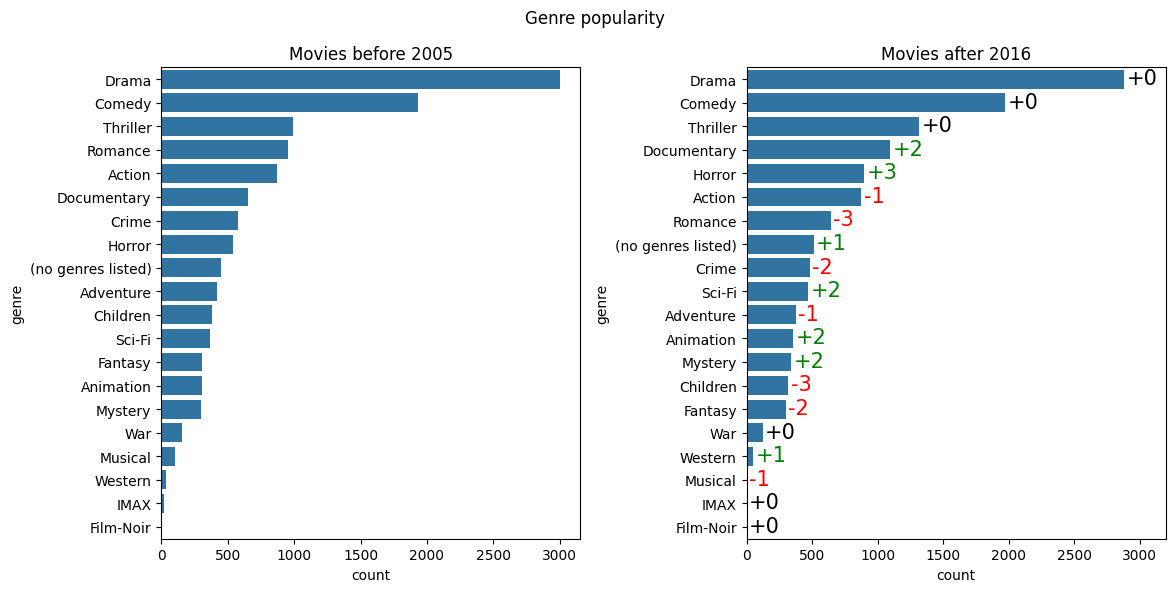

In [18]:
before = get_genre_frequency_df(movies, year_upper_bound=2005).reset_index()
after = get_genre_frequency_df(movies, year_lower_bound=2016).reset_index()
changes = pd.merge(after, before, how='inner', on='genre')
changes = changes['index_y'] - changes['index_x']
changes = changes.to_list()

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
sns.barplot(
    before,
    x='count',
    y='genre',
    orient='h',
    ax=axs[0],
)
plot = sns.barplot(
    after,
    x='count',
    y='genre',
    orient='h',
    ax=axs[1],
)

# inspo from https://www.geeksforgeeks.org/how-to-annotate-bars-in-barplot-with-matplotlib-in-python/
for i, bar in enumerate(plot.patches):
    c = 'black'
    if changes[i] > 0:
        c = 'green'
    elif changes[i] < 0:
        c = 'red'

    plot.annotate(
        format(changes[i], '+'),
        (bar.get_width() + 20, bar.get_y() + bar.get_height() / 2),
        ha='left',
        va='top',
        size=15,
        xytext=(0, 8),
        textcoords='offset points',
        color=c,
    )

plt.suptitle('Genre popularity')
axs[0].set_title('Movies before 2005')
axs[1].set_title('Movies after 2016')
plt.tight_layout()
axs[1].set_xlim([0, 3200])
plt.show()

<font size="+1" color="red">Replace this cell with a brief commentary comparing both distributions, including which genres changed popularity.</font>

From what we can see in the above plots, the top 3 genres (Drama, Comedy, Thriller) have not changed. We also see that there are some 'dead' genres (War, IMAX and Film-Noir) that have not increased nor decreased in popularity. The genres that have decreased in popularity are mostly Romance, Children, Crime, Fantasy and Musical. The genres that have increased in popularity are mostly Horror, Documentary, Sci-Fi, Animation, Mistery and Western.

# 3. Content-based recommendation

## 3.1. Compute TF-IDF vectors

<font size="+1" color="red">Replace this cell with your code to add column "genres_arr" to the dataframe "movies".</font>

In [19]:
display(movies.head(5))

,movie_id,title,genres,year
0,2769,"Yards, The (2000)",Crime|Drama,2000
1,3177,Next Friday (2000),Comedy,2000
2,3190,Supernova (2000),Adventure|Sci-Fi|Thriller,2000
3,3225,Down to You (2000),Comedy|Romance,2000
4,3228,Wirey Spindell (2000),Comedy,2000


In [20]:
movies['genres_arr'] = movies['genres'].str.split(r'|').fillna('').astype('str')

In [21]:
# Leave this code as-is

print("Transformed: %s → %s" % (movies['genres'][3], movies['genres_arr'][3]))

Transformed: Comedy|Romance → ['Comedy', 'Romance']


In [22]:
# LEAVE AS-IS

# The reset-index is important to match row/column numbers in the tdifd-matrix

movies_filtered = movies[movies.year >= 2016]
movies_filtered = movies_filtered.reset_index()
display(movies_filtered.head(5))

,index,movie_id,title,genres,year,genres_arr
0,10897,122888,Ben-hur (2016),(no genres listed),2016,['(no genres listed)']
1,10898,122890,Warcraft (2016),Action|Adventure|Fantasy,2016,"['Action', 'Adventure', 'Fantasy']"
2,10900,122896,Pirates of the Caribbean: Dead Men Tell No Tal...,(no genres listed),2017,['(no genres listed)']
3,10901,122898,Justice League (2017),Action|Adventure|Sci-Fi,2017,"['Action', 'Adventure', 'Sci-Fi']"
4,10904,122904,Deadpool (2016),Action|Adventure|Comedy|Sci-Fi,2016,"['Action', 'Adventure', 'Comedy', 'Sci-Fi']"


<font size="+1" color="red">Replace this cell with your code to generate "tfidf_matrix"</font>

In [23]:
tfidf_matrix = TfidfVectorizer(ngram_range=(1, 2), stop_words='english').fit_transform(
    movies_filtered['genres_arr']
)
tfidf_matrix.shape

(7890, 128)

## 3.2. Calculate most similar movies

In [24]:
# Leave this code as-is

cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)
print(cosine_sim)

[[1.         0.         1.         ... 1.         0.         0.        ]
 [0.         1.         0.         ... 0.         0.         0.        ]
 [1.         0.         1.         ... 1.         0.         0.        ]
 ...
 [1.         0.         1.         ... 1.         0.         0.        ]
 [0.         0.         0.         ... 0.         1.         0.41022264]
 [0.         0.         0.         ... 0.         0.41022264 1.        ]]


In [25]:
# Leave this code as-is

# Create an index to convert from numbers to movie_id
movie_id_to_index = pd.Series(movies_filtered.index, index=movies_filtered['movie_id'])


# Print the similarity vector
def print_similarity_vector(movie_id, similarities):

    # Determine the index of the movie_id
    index_source = movie_id_to_index[movie_id]

    # Get the row in the similarities matrix
    sim_scores = list(similarities[index_source])

    # Iterate through that row
    for index_target in range(len(sim_scores)):
        print(
            "%.3f %d %s"
            % (
                sim_scores[index_target],
                movies_filtered.iloc[index_target].movie_id,
                movies_filtered.iloc[index_target].title,
            )
        )


print_similarity_vector(122904, cosine_sim)

0.000 122888 Ben-hur (2016)
0.362 122890 Warcraft (2016)
0.000 122896 Pirates of the Caribbean: Dead Men Tell No Tales (2017)
0.600 122898 Justice League (2017)
1.000 122904 Deadpool (2016)
0.600 122906 Black Panther (2017)
0.600 122908 Inhumans (2018)
0.600 122910 Captain Marvel (2018)
0.600 122912 Avengers: Infinity War - Part I (2018)
0.600 122914 Avengers: Infinity War - Part II (2019)
0.600 122916 Thor: Ragnarok (2017)
0.600 122918 Guardians of the Galaxy 2 (2017)
0.359 122920 Captain America: Civil War (2016)
0.600 122922 Doctor Strange (2016)
0.504 122924 X-Men: Apocalypse (2016)
0.362 122926 Untitled Spider-Man Reboot (2017)
0.440 135141 Allegiant: Part 1 (2016)
0.000 135143 Fantastic Beasts and Where to Find Them (2016)
0.000 135426 Fantastic Beasts and Where to Find Them 2 (2018)
0.056 135436 The Secret Life of Pets (2016)
0.326 135530 Criminal (2016)
0.309 135536 Suicide Squad (2016)
0.600 135567 Independence Day: Resurgence (2016)
0.600 135569 Star Trek Beyond (2016)
0.000 

<font size="+1" color="red">Replace this cell with your code for "genre_content_based_recommendations"</font>

In [26]:
def genre_content_based_recommendations(movie_id, movies, similarities, num_movies=10):

    index_source = movie_id_to_index[movie_id]

    enumerated = list(enumerate(similarities[index_source]))
    top_similarities = sorted(enumerated, key=lambda x: x[1], reverse=True)
    top_similarities = top_similarities[0:num_movies]

    recommendations = []
    for index_target, similarity in top_similarities:

        movie = movies.iloc[index_target]

        recommendations.append(
            {
                'movie_id': movie.movie_id,
                'title': movie.title,
                'genres': movie.genres,
                'similarity': similarity,
            }
        )

    return pd.DataFrame.from_records(
        recommendations, columns=['similarity', 'movie_id', 'title', 'genres']
    )

<font size="+1" color="red">Replace this cell with code to print the top 10 recommendations for movie "Pirates of the Caribbean" (movie_id=122896) and "Midsommer" (movie_id=201646).</font>

In [27]:
genre_content_based_recommendations(122896, movies_filtered, cosine_sim)

,similarity,movie_id,title,genres
0,1.0,122888,Ben-hur (2016),(no genres listed)
1,1.0,122896,Pirates of the Caribbean: Dead Men Tell No Tal...,(no genres listed)
2,1.0,135426,Fantastic Beasts and Where to Find Them 2 (2018),(no genres listed)
3,1.0,138212,Spectral (2016),(no genres listed)
4,1.0,141131,Guardians (2016),(no genres listed)
5,1.0,143387,Pitch Perfect 3 (2017),(no genres listed)
6,1.0,150724,Army Dog (2016),(no genres listed)
7,1.0,151461,Fitoor (2016),(no genres listed)
8,1.0,151593,Martyrs (2016),(no genres listed)
9,1.0,152037,Grease Live (2016),(no genres listed)


In [28]:
genre_content_based_recommendations(201646, movies_filtered, cosine_sim)

,similarity,movie_id,title,genres
0,1.0,155064,The Neon Demon (2016),Drama|Horror|Mystery
1,1.0,162460,The Childhood of a Leader (2016),Drama|Horror|Mystery
2,1.0,162628,Phantom of the Theatre (2016),Drama|Horror|Mystery
3,1.0,167786,When the Bough Breaks (2016),Drama|Horror|Mystery
4,1.0,184067,Without Name (2017),Drama|Horror|Mystery
5,1.0,190755,The Little Stranger (2018),Drama|Horror|Mystery
6,1.0,192291,Rift (2017),Drama|Horror|Mystery
7,1.0,201646,Midsommar (2019),Drama|Horror|Mystery
8,1.0,201739,Wounds (2019),Drama|Horror|Mystery
9,1.0,202225,Something (2018),Drama|Horror|Mystery


<font size="+1" color="red">Replace this cell with code to get the list of recommendation for three movies you are familiar with. Indicate the **precision** of each list, which is the percentage of recommended movies that *you* consider relevant (mark manually as "relevant" or "irrelevant" each recommendation). Indicate the **average precision** across the three lists.</font> 

In [29]:
# An Avengers movie
scifi_recommendations = genre_content_based_recommendations(
    122912, movies_filtered, cosine_sim
).set_index('movie_id')
scifi_recommendations['relevant'] = True
scifi_recommendations.loc[135567, 'relevant'] = False
display(scifi_recommendations)

,similarity,title,genres,relevant
movie_id,,,,
122898,1.0,Justice League (2017),Action|Adventure|Sci-Fi,True
122906,1.0,Black Panther (2017),Action|Adventure|Sci-Fi,True
122908,1.0,Inhumans (2018),Action|Adventure|Sci-Fi,True
122910,1.0,Captain Marvel (2018),Action|Adventure|Sci-Fi,True
122912,1.0,Avengers: Infinity War - Part I (2018),Action|Adventure|Sci-Fi,True
122914,1.0,Avengers: Infinity War - Part II (2019),Action|Adventure|Sci-Fi,True
122916,1.0,Thor: Ragnarok (2017),Action|Adventure|Sci-Fi,True
122918,1.0,Guardians of the Galaxy 2 (2017),Action|Adventure|Sci-Fi,True
122922,1.0,Doctor Strange (2016),Action|Adventure|Sci-Fi,True


The only non-MCU movie in this list is `Independence Day: Resurgence (2016)` which I've never seen but from the trailer seems legit to be in this list (a very american sci-fi action movie).

In [30]:
# Dunkirk movie
war_recommendations = genre_content_based_recommendations(
    174055, movies_filtered, cosine_sim
).set_index('movie_id')
war_recommendations['relevant'] = True
war_recommendations.loc[155288, 'relevant'] = False
war_recommendations.loc[167848, 'relevant'] = False
display(war_recommendations)

,similarity,title,genres,relevant
movie_id,,,,
174055,1.000000,Dunkirk (2017),Action|Drama|Thriller|War,True
193447,1.000000,The Angel (2018),Action|Drama|Thriller|War,True
155288,0.864556,Eye in the Sky (2016),Drama|Thriller|War,False
167848,0.864556,Burn Country (2016),Drama|Thriller|War,False
174645,0.864556,Churchill (2017),Drama|Thriller|War,True
183417,0.864556,The Battleship Island (2017),Drama|Thriller|War,True
184751,0.864556,Take Off (2017),Drama|Thriller|War,True
201238,0.864556,"Call Sign ""Banderas"" (2018)",Drama|Thriller|War,True
193221,0.767258,Trench 11 (2017),Thriller|War,True


The two movies that I would consider "irrelevant" are: `Eye in the Sky (2016)` (kind of sci-fi, at least not history-based) and `Burn Country (2016)` (not war-themed).

In [31]:
# L'abbiamo fatta grossa movie
comedy_recommendations = genre_content_based_recommendations(
    152862, movies_filtered, cosine_sim
).set_index('movie_id')
comedy_recommendations['relevant'] = True
display(comedy_recommendations)

,similarity,title,genres,relevant
movie_id,,,,
143859,1.0,"Hail, Caesar! (2016)",Comedy,True
148888,1.0,Zoolander 2 (2016),Comedy,True
150194,1.0,Quo vado? (2016),Comedy,True
151311,1.0,Wiener-Dog (2016),Comedy,True
151455,1.0,Eddie the Eagle (2016),Comedy,True
151739,1.0,Dirty Grandpa (2016),Comedy,True
152069,1.0,Busco Novio Para Mi Mujer (2016),Comedy,True
152091,1.0,The Brothers Grimsby (2016),Comedy,True
152248,1.0,Rosalie Blum (2016),Comedy,True


All these movies are valid in my opinion.

In [32]:
print(f'Precicion for scifi movies: {scifi_recommendations['relevant'].mean():>4}')
print(f'Precicion for war movies: {war_recommendations['relevant'].mean():>6}')
print(f'Precicion for comedy movies: {comedy_recommendations['relevant'].mean():>3}')

Precicion for scifi movies:  0.9
Precicion for war movies:    0.8
Precicion for comedy movies: 1.0


<font size="+1" color="red">Replace this cell with ideas on how you would improve **this** content-based recommendations, based on what we discussed in class about content-based recommendations.</font>

With this approach we are only taking into account the genres of the movies, so we really are not taking into account how the movies are received by the audience. There might be movies that, even belonging to the same genres and/or franchise, is so badly produced that the recommendation will be inaccurate. For this means it would be more accurate an interaction-based recommender system.

An improvement that I would make to this specific content-based recommender system is to remove the movie that is being queried from the results (always is going to have similarity of 1). In addition to that, we could try to look at more features other than solely the genre (not in this dataset, though). Lastly, we could try to implement other similarity metrics other than the cosine similarity (There are many other options already implemented as we can see in the [Scikit-learn documentation](https://scikit-learn.org/1.5/modules/metrics.html)).

<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, report, and figures were produced by myself.</font>